In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install ultralytics 

# # Clone YOLOv5 repository
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# !pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.8/949.8 kB 17.7 MB/s eta 0:00:0000:01


In [3]:
import os
import pandas as pd
import numpy as np
import yaml
from pathlib import Path
import shutil
import random
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

from ultralytics import YOLO

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [4]:
# Set up paths for Kaggle environment
input_path = '/kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data'
# Use the working directory for output, which is writable in Kaggle
output_path = '/kaggle/working'
train_images_path = os.path.join(input_path, 'train/images')
train_labels_path = os.path.join(input_path, 'train/labels')
test_images_path = os.path.join(input_path, 'test/images')

# Create a new dataset directory structure in the writable space
dataset_dir = os.path.join(output_path, 'mosquito_dataset')
os.makedirs(dataset_dir, exist_ok=True)

In [5]:
print("Creating validation split from training data...")

# Create directory structure for training and validation (in writable space)
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'valid')
os.makedirs(os.path.join(train_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'labels'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'labels'), exist_ok=True)

# Get list of training images (without extension for easier matching)
train_images = [os.path.splitext(f)[0] for f in os.listdir(train_images_path) if os.path.isfile(os.path.join(train_images_path, f))]
print(f"Total training images: {len(train_images)}")

# Split into training and validation sets (10% for validation)
train_files, val_files = train_test_split(train_images, test_size=0.1, random_state=42)
print(f"After split: {len(train_files)} training, {len(val_files)} validation")

print("Copying training and validation files...")

# Function to copy files with progress tracking
def copy_files(file_list, src_img_dir, src_label_dir, dst_img_dir, dst_label_dir):
    for i, base_name in enumerate(file_list):
        if i % 500 == 0:
            print(f"Processed {i}/{len(file_list)} files...")
            
        # Find image file with any extension
        img_files = [f for f in os.listdir(src_img_dir) if f.startswith(base_name + '.')]
        if img_files:
            img_file = img_files[0]
            # Copy image
            src_img = os.path.join(src_img_dir, img_file)
            dst_img = os.path.join(dst_img_dir, img_file)
            shutil.copy(src_img, dst_img)
            
            # Copy corresponding label file
            label_file = base_name + '.txt'
            src_label = os.path.join(src_label_dir, label_file)
            dst_label = os.path.join(dst_label_dir, label_file)
            
            if os.path.exists(src_label):
                shutil.copy(src_label, dst_label)

# Copy training files
copy_files(train_files, train_images_path, train_labels_path, 
           os.path.join(train_dir, 'images'), os.path.join(train_dir, 'labels'))

# Copy validation files
copy_files(val_files, train_images_path, train_labels_path, 
           os.path.join(val_dir, 'images'), os.path.join(val_dir, 'labels'))

# Verify split
print(f"Training images copied: {len(os.listdir(os.path.join(train_dir, 'images')))}")
print(f"Training labels copied: {len(os.listdir(os.path.join(train_dir, 'labels')))}")
print(f"Validation images copied: {len(os.listdir(os.path.join(val_dir, 'images')))}")
print(f"Validation labels copied: {len(os.listdir(os.path.join(val_dir, 'labels')))}")

Creating validation split from training data...
Total training images: 7500
After split: 6750 training, 750 validation
Copying training and validation files...
Processed 0/6750 files...
Processed 500/6750 files...
Processed 1000/6750 files...
Processed 1500/6750 files...
Processed 2000/6750 files...
Processed 2500/6750 files...
Processed 3000/6750 files...
Processed 3500/6750 files...
Processed 4000/6750 files...
Processed 4500/6750 files...
Processed 5000/6750 files...
Processed 5500/6750 files...
Processed 6000/6750 files...
Processed 6500/6750 files...
Processed 0/750 files...
Processed 500/750 files...
Training images copied: 6750
Training labels copied: 6750
Validation images copied: 750
Validation labels copied: 750


In [6]:
def augment_target_classes(class_augmentation_counts):
    """
    Augments images containing the specified target classes with the required number of augmentations.
    
    :param class_augmentation_counts: Dictionary mapping class IDs to the number of augmentations required.
    :return: Total number of augmented images created.
    """
    train_img_dir = os.path.join(train_dir, 'images')
    train_label_dir = os.path.join(train_dir, 'labels')
    
    # Find all training files containing the target classes
    files_with_target_classes = []
    for label_file in os.listdir(train_label_dir):
        if not label_file.endswith('.txt'):
            continue
        
        label_path = os.path.join(train_label_dir, label_file)
        base_name = os.path.splitext(label_file)[0]
        
        # Check if this file contains target classes
        with open(label_path, 'r') as f:
            for line in f:
                class_id = int(line.strip().split()[0])
                if class_id in class_augmentation_counts:
                    img_files = [f for f in os.listdir(train_img_dir) if f.startswith(base_name + '.')]
                    if img_files:
                        files_with_target_classes.append((base_name, img_files[0], class_id))
                    break
    
    print(f"Found {len(files_with_target_classes)} files with target classes.")
    
    # Define augmentation pipeline
    augmentations = [
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.Rotate(limit=20, p=0.5),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    ]
    
    augmentation_count = 0
    
    for base_name, img_file, class_id in tqdm(files_with_target_classes):
        num_augmentations = class_augmentation_counts.get(class_id, 0)
        if num_augmentations == 0:
            continue
        
        # Source paths
        src_img_path = os.path.join(train_img_dir, img_file)
        src_label_path = os.path.join(train_label_dir, base_name + '.txt')
        
        # Read image
        image = cv2.imread(src_img_path)
        if image is None:
            continue
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height, width, _ = image.shape
        
        # Read labels
        bboxes = []
        class_ids = []
        with open(src_label_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 5:
                    label_class_id = int(parts[0])
                    x_center = float(parts[1])
                    y_center = float(parts[2])
                    w = float(parts[3])
                    h = float(parts[4])
                    
                    x_min = (x_center - w/2) * width
                    y_min = (y_center - h/2) * height
                    x_max = (x_center + w/2) * width
                    y_max = (y_center + h/2) * height
                    
                    bboxes.append([x_min, y_min, x_max, y_max])
                    class_ids.append(label_class_id)
        
        # Apply augmentations
        for aug_idx in range(num_augmentations):
            transform = A.Compose(
                random.sample(augmentations, k=random.randint(2, 4)),
                bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_ids'])
            )
            
            try:
                augmented = transform(image=image, bboxes=bboxes, class_ids=class_ids)
                aug_image = augmented['image']
                aug_bboxes = augmented['bboxes']
                aug_class_ids = augmented['class_ids']
            except Exception as e:
                print(f"Error during augmentation: {e}")
                continue
            
            if len(aug_bboxes) == 0:
                continue
            
            aug_base_name = f"{base_name}_aug_{aug_idx}"
            aug_img_file = f"{aug_base_name}.jpg"
            aug_img_path = os.path.join(train_img_dir, aug_img_file)
            cv2.imwrite(aug_img_path, cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR))
            
            with open(os.path.join(train_label_dir, f"{aug_base_name}.txt"), 'w') as f:
                for bbox, aug_class_id in zip(aug_bboxes, aug_class_ids):
                    x_min, y_min, x_max, y_max = bbox
                    x_center = (x_min + x_max) / (2 * width)
                    y_center = (y_min + y_max) / (2 * height)
                    w = (x_max - x_min) / width
                    h = (y_max - y_min) / height
                    
                    f.write(f"{aug_class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")
            
            augmentation_count += 1
    
    print(f"Created {augmentation_count} augmented images.")
    return augmentation_count

# Example usage: Specify classes and required augmentations
class_augmentation_counts = {
    0: 6,  
    2: 6,
    #4: 2,
    #5: 2
}

augmented_count = augment_target_classes(class_augmentation_counts)

# Print dataset stats
print(f"Dataset after augmentation:")
print(f"Training images: {len(os.listdir(os.path.join(train_dir, 'images')))}")
print(f"Training labels: {len(os.listdir(os.path.join(train_dir, 'labels')))}")

Found 84 files with target classes.


  1%|          | 1/84 [00:04<06:06,  4.41s/it]/usr/local/lib/python3.10/dist-packages/albumentations/core/composition.py:205: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()
100%|██████████| 84/84 [02:02<00:00,  1.46s/it]

Created 504 augmented images.
Dataset after augmentation:
Training images: 7254
Training labels: 7254


In [7]:
class_dict = {
    "aegypti": 0,
    "albopictus": 1,
    "anopheles": 2,
    "culex": 3,
    "culiseta": 4,
    "japonicus/koreicus": 5
}

# Create YAML content with paths relative to YOLOv5 directory
yaml_content = {
    'path': dataset_dir,  # Using our new dataset directory
    'train': 'train/images',
    'val': 'valid/images',
    'nc': 6,
    'names': list(class_dict.keys())
}

import os
import yaml

# Ensure the directory exists
os.makedirs("data", exist_ok=True)

# Save YAML file
with open("data/mosquito.yaml", "w") as f:
    yaml.dump(yaml_content, f, default_flow_style=False)

print("Dataset YAML created at data/mosquito.yaml")

Dataset YAML created at data/mosquito.yaml


In [9]:
# Set training parameters
img_size = 640
batch_size = 64
epochs = 40

# Start training
model = YOLO("yolo11s.pt")
model.train(data="data/mosquito.yaml", epochs=epochs, batch=batch_size, imgsz=img_size, device=0, cache=True)

100%|██████████| 18.4M/18.4M [00:00<00:00, 165MB/s]


Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolo11s.pt, data=data/mosquito.yaml, epochs=40, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 755k/755k [00:00<00:00, 17.7MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 73.5MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/mosquito_dataset/train/labels... 3808 images, 0 backgrounds, 1 corrupt:  52%|█████▏    | 3808/7254 [00:02<00:02, 1275.99it/s]/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3406: DecompressionBombWarning: Image size (108000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
train: Scanning /kaggle/working/mosquito_dataset/train/labels... 7254 images, 0 backgrounds, 1 corrupt: 100%|██████████| 7254/7254 [00:05<00:00, 1267.15it/s]

train: WARNING ⚠️ /kaggle/working/mosquito_dataset/train/images/120b30b0-c7db-4f0a-bead-a30424a65453.jpeg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0068]


train: New cache created: /kaggle/working/mosquito_dataset/train/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (5.9GB RAM): 100%|██████████| 7253/7253 [02:20<00:00, 51.50it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/mosquito_dataset/valid/labels... 750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 750/750 [00:00<00:00, 1329.11it/s]


val: New cache created: /kaggle/working/mosquito_dataset/valid/labels.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.6GB RAM): 100%|██████████| 750/750 [00:15<00:00, 49.64it/s] 


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40      14.5G      1.293      2.509      1.367         50        640: 100%|██████████| 114/114 [02:16<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.24s/it]

                   all        750        750      0.277      0.385      0.292      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40      14.5G      1.207      1.274      1.311         51        640: 100%|██████████| 114/114 [02:24<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        750        750      0.413      0.228      0.216      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40      14.4G      1.248       1.28      1.335         39        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750       0.24      0.296      0.265      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40      14.4G       1.24      1.227      1.333         35        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        750        750      0.205      0.303      0.224      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40      14.4G       1.16      1.122       1.28         41        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        750        750      0.461      0.277      0.296      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40      14.4G       1.11      1.024      1.252         45        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750       0.45      0.406      0.302      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40      14.4G      1.077     0.9648      1.228         48        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        750        750      0.385      0.426      0.368      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40      14.4G      1.033     0.9077      1.201         38        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750      0.467      0.374      0.343      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40      14.4G          1     0.8796      1.189         42        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        750        750      0.394      0.401      0.363      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40      14.4G     0.9713     0.8348      1.171         44        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750      0.488       0.38      0.322      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40      14.4G     0.9351     0.7971      1.152         44        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.00s/it]

                   all        750        750      0.357      0.392      0.367      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40      14.4G      0.918     0.7542      1.142         36        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750      0.348      0.484      0.373      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40      14.4G     0.8972     0.7439      1.131         50        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750       0.38      0.343      0.351      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40      14.4G      0.874     0.7244      1.122         37        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750      0.352      0.383       0.38      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40      14.4G     0.8568     0.6958       1.11         48        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750      0.575      0.323      0.353      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40      14.4G     0.8284     0.6784      1.099         46        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750      0.585      0.362      0.376      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/40      14.4G     0.8162     0.6625      1.092         41        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750      0.615      0.419      0.441      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/40      14.4G     0.7818     0.6311      1.071         42        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750      0.353      0.466      0.389      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/40      14.4G     0.7838     0.6296      1.074         49        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.01s/it]

                   all        750        750      0.504      0.416      0.434      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/40      14.4G     0.7617     0.6111      1.062         39        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750        0.4      0.449      0.387      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/40      14.4G     0.7452     0.5977      1.051         48        640: 100%|██████████| 114/114 [02:23<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        750        750      0.585      0.401      0.409      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/40      14.4G     0.7323     0.5738       1.05         47        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750      0.373      0.489      0.428      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/40      14.4G     0.7243      0.562      1.043         47        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750      0.407      0.496      0.442      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/40      14.4G     0.6989     0.5506      1.032         41        640: 100%|██████████| 114/114 [02:23<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750      0.457      0.405      0.447      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/40      14.4G      0.685      0.535      1.028         44        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        750        750      0.428      0.476      0.452      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/40      14.4G     0.6774     0.5253      1.023         44        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        750        750      0.539       0.46      0.476      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/40      14.4G     0.6691     0.5168      1.018         43        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        750        750      0.438      0.481      0.457      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/40      14.4G     0.6471     0.5018      1.008         51        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750      0.449      0.439       0.45      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/40      14.4G     0.6362     0.4946      1.007         45        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750      0.505      0.456      0.474      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/40      14.4G     0.6308     0.4871      1.005         52        640: 100%|██████████| 114/114 [02:23<00:00,  1.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750      0.412      0.608      0.472      0.349


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/40      14.3G     0.9062     0.6872      1.137         21        640: 100%|██████████| 114/114 [02:24<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        750        750      0.417      0.509      0.468      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/40      14.3G     0.8734     0.6458      1.106         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.04it/s]

                   all        750        750      0.495      0.492      0.485      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/40      14.3G     0.8582     0.6184      1.093         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750      0.483      0.468       0.51      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/40      14.3G     0.8432     0.5903      1.087         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.03it/s]

                   all        750        750      0.497      0.541      0.495      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/40      14.3G     0.8279     0.5743      1.077         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.01it/s]

                   all        750        750      0.454      0.507      0.505       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/40      14.3G     0.8148     0.5424      1.068         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750      0.547      0.465      0.519      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/40      14.4G     0.8022     0.5272      1.063         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:06<00:00,  1.02s/it]

                   all        750        750      0.518      0.514      0.535      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/40      14.3G     0.7877     0.5058      1.053         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750      0.492      0.573      0.526       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/40      14.3G     0.7725     0.4933      1.042         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.02it/s]

                   all        750        750       0.58      0.496      0.535      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/40      14.3G     0.7716     0.4747      1.041         21        640: 100%|██████████| 114/114 [02:22<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:05<00:00,  1.05it/s]

                   all        750        750      0.526      0.508      0.539      0.419



40 epochs completed in 1.664 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 19.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 19.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.94 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15095MiB)
YOLO11s summary (fused): 100 layers, 9,415,122 parameters, 0 gradients, 21.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:08<00:00,  1.40s/it]


                   all        750        750      0.526      0.508      0.538      0.419
               aegypti          5          5      0.271        0.2      0.196      0.176
            albopictus        345        345      0.898       0.87      0.934      0.721
             anopheles          5          5          0          0     0.0852     0.0519
                 culex        318        318      0.871      0.912      0.928      0.718
              culiseta         48         48      0.724      0.625      0.696      0.533
    japonicus/koreicus         29         29       0.39      0.441      0.393      0.316


/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


Speed: 0.1ms preprocess, 5.2ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7feca13c6410>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
     

In [10]:
# Load YOLOv8 model
model = YOLO("runs/detect/train/weights/best.pt")

# Run inference
results = model.predict(source="/kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images", imgsz=img_size, conf=0.25, save=True, save_txt=True, save_conf=True)


image 1/525 /kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images/0031063e-716a-4080-934c-77598dc8de72.jpeg: 640x480 1 culex, 48.2ms
image 2/525 /kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images/00fbfad7-9722-4581-831c-79faa576ea7f.jpeg: 640x480 1 aegypti, 12.4ms
image 3/525 /kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images/02043b0e-3d7d-4ca4-a36f-4bf97c344264.jpeg: 640x384 1 culex, 48.5ms
image 4/525 /kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images/0365513c-8f00-44f3-abd0-1fadde81c602.jpeg: 640x480 1 culex, 13.0ms
image 5/525 /kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images/0365d78b-2064-4d54-b15c-994d1950479a.jpeg: 640x512 2 albopictuss, 47.0ms
image 6/525 /kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images/03d6749a-c5b3-45a3-81fa-b9c2f09eb4ba.jpeg: 576x640 1 albopictus, 46.6ms
im

In [11]:
# Directories
image_dir = "/kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images"
predictions_dir = '/kaggle/working/runs/detect/predict/labels'

# Load the sample submission to get the correct order
sample_df = pd.read_csv("/kaggle/input/dlp-object-detection-week-10/sample_submission.csv")

# Get the ordered list of ImageIds from the sample submission
ordered_image_ids = sample_df['ImageID'].unique()

# Create a dictionary to store the best prediction for each image
best_predictions = {}

# Process prediction files
for file in os.listdir(predictions_dir):
    if file.endswith('.txt'):
        image_id = file.split('.')[0]
        image_id += ".jpeg"
        predictions = []

        with open(os.path.join(predictions_dir, file), 'r') as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                
                values = line.split()
                class_idx = int(values[0])
                x_center = float(values[1])
                y_center = float(values[2])
                width = float(values[3])
                height = float(values[4])
                conf = float(values[5]) if len(values) > 5 else 1.0
                
                class_name = list(class_dict.keys())[class_idx]

                predictions.append({
                    'ImageID': image_id,
                    'LabelName': class_name,
                    'Conf': conf,
                    'xcenter': x_center,
                    'ycenter': y_center,
                    'bbx_width': width,
                    'bbx_height': height
                })

        # Keep only the highest confidence prediction
        if predictions:
            best_prediction = max(predictions, key=lambda x: x['Conf'])
            best_predictions[image_id] = best_prediction

# Create results list following the order in sample submission
results = []
for image_id in ordered_image_ids:
    if image_id in best_predictions:
        results.append(best_predictions[image_id])
    else:
        # For images without predictions, use a default placeholder prediction
        # Choosing class 1 (albopictus) with medium confidence as a default
        results.append({
            'ImageID': image_id,
            'LabelName': 'albopictus',
            'Conf': 0.5,
            'xcenter': 0.5,
            'ycenter': 0.5,
            'bbx_width': 0.1,
            'bbx_height': 0.1
        })

# Create DataFrame
submission_df = pd.DataFrame(results)
submission_df['id'] = range(len(submission_df))
submission_df = submission_df[['id', 'ImageID', 'LabelName', 'Conf', 'xcenter', 'ycenter', 'bbx_width', 'bbx_height']]

# Save submission file
submission_file = os.path.join(output_path, 'submission.csv')
submission_df.to_csv(submission_file, index=False)
print(f"Submission file created at {submission_file} with {len(submission_df)} entries")

Submission file created at /kaggle/working/submission.csv with 525 entries


In [12]:
print("\nSubmission Statistics:")
print(f"Total predictions in submission: {len(submission_df)}")
print("Predictions per class:")
class_counts = submission_df['LabelName'].value_counts()
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count}")

# Average confidence score
print(f"Average confidence score: {submission_df['Conf'].mean():.2f}")


Submission Statistics:
Total predictions in submission: 525
Predictions per class:
  albopictus: 241
  culex: 236
  culiseta: 23
  japonicus/koreicus: 21
  aegypti: 3
  anopheles: 1
Average confidence score: 0.76


In [13]:
df = pd.read_csv("/kaggle/working/submission.csv")
df

,id,ImageID,LabelName,Conf,xcenter,ycenter,bbx_width,bbx_height
0,0,16dbbc39-fcb6-498e-963f-d3807fcc3cec.jpeg,albopictus,0.838216,0.432132,0.446017,0.136492,0.113430
1,1,7daa68bd-928b-4b43-850f-4626f16d2c14.jpeg,albopictus,0.876207,0.495607,0.559794,0.438468,0.302409
2,2,bb0986d9-fa04-40a5-8de2-c54045537e17.jpeg,albopictus,0.813306,0.357001,0.469976,0.105161,0.168231
3,3,11924d04-69fe-469d-8d1c-119bc0f0b94f.jpeg,culiseta,0.685485,0.632053,0.616348,0.735893,0.767305
4,4,db4ade79-fce4-4d77-a8fa-36b9e77dfd08.jpeg,culex,0.549301,0.367280,0.470252,0.178714,0.121657
...,...,...,...,...,...,...,...,...
520,520,b719ddba-3666-4dfd-848b-afe465d4dd5c.jpeg,albopictus,0.804703,0.434539,0.656521,0.282324,0.240251
521,521,87573bc0-f7fd-4da6-b085-c331d740039f.jpeg,albopictus,0.845623,0.480919,0.473683,0.153877,0.129107
522,522,3a918cb9-770c-4e13-8201-90858c25c7d0.jpeg,culex,0.625368,0.364349,0.547770,0.111236,0.089174
523,523,da0226ce-ef8f-4217-bd5d-38955a232eab.jpeg,japonicus/koreicus,0.648439,0.479941,0.514142,0.832767,0.938063


In [14]:
import shutil
import os

dir_path = "/kaggle/working/mosquito_dataset"  # Change this to the directory you want to delete

if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
    print(f"Deleted directory: {dir_path}")
else:
    print(f"Directory not found: {dir_path}")

Deleted directory: /kaggle/working/mosquito_dataset


In [15]:
import shutil
import os

dir_path = "/kaggle/working/runs"  # Change this to the directory you want to delete

if os.path.exists(dir_path):
    shutil.rmtree(dir_path)
    print(f"Deleted directory: {dir_path}")
else:
    print(f"Directory not found: {dir_path}")

Deleted directory: /kaggle/working/runs


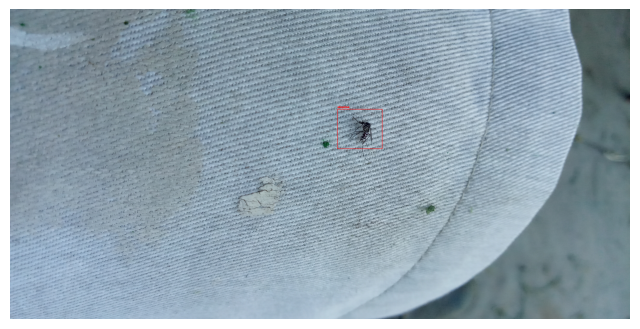

In [16]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt

# Directories
image_dir = "/kaggle/input/dlp-object-detection-week-10/final_dlp_data/final_dlp_data/test/images"
submission_file = "/kaggle/working/submission.csv"

def plot_bounding_boxes(image_id):
    image_path = os.path.join(image_dir, image_id)
    
    if not os.path.exists(image_path):
        print(f"Image {image_id} not found!")
        return
    
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = image.shape
    
    # Load bounding box details from CSV
    df = pd.read_csv(submission_file)
    image_df = df[df['ImageID'] == image_id]
    
    if image_df.empty:
        print(f"No bounding boxes found for {image_id}")
    else:
        for _, row in image_df.iterrows():
            class_name = row['LabelName']
            x_center = row['xcenter'] * width
            y_center = row['ycenter'] * height
            box_width = row['bbx_width'] * width
            box_height = row['bbx_height'] * height
            
            x1 = int(x_center - box_width / 2)
            y1 = int(y_center - box_height / 2)
            x2 = int(x_center + box_width / 2)
            y2 = int(y_center + box_height / 2)
            
            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
            cv2.putText(image, class_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
    
    # Show image
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# Example usage
image_id = "ca1468e3-1337-48b3-b378-135758317454.jpeg"  # Replace with the actual image ID
plot_bounding_boxes(image_id)